In [1]:
# Imports of the packages needed for the implementation 
import mne as mne
from mne.preprocessing import ICA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from pylab import *
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [2]:
# Reading the training data from the folders 
S001 = "final-concatenation/S001/Training data/S001-final-concat.csv"
S002 = "final-concatenation/S002/Training data/S002-final-concat.csv"
S003 = "final-concatenation/S003/Training data/S003-final-concat.csv"
S004 = "final-concatenation/S004/Training data/S004-final-concat.csv"
#S005 = "final-concatenation/S005/Training data/S005-final-concat.csv"
#S006 = "final-concatenation/S006/Training data/S006-final-concat.csv"
#S007 = "final-concatenation/S007/Training data/S007-final-concat.csv"
#S008 = "final-concatenation/S008/Training data/S008-final-concat.csv"
#S009 = "final-concatenation/S009/Training data/S009-final-concat.csv"
#S010 = "final-concatenation/S010/Training data/S010-final-concat.csv"

#S004, S005, S006, S007, S008, S009, S010

# Form a list of files for the subjects training data
file_list = [S001, S002, S003, S004]

In [3]:
#This definition reads a csv file by opening it and reading using a csv reader from panda
# It drops the channels that are not going to be used for implementation, we want to focus on the channel 
# that helps with person identification. It then transposes the data so it creates an array list of the 
# each of the subjects data, we then identified the channel name that will be used and create information
# of the eeg data. we then create a raw array using an mne tool which is used for the analyses of EEG data
# It then filters the dataset and creates epochs and time points which will be fed into the classiifcation method 
# or will be used to extract features and returns the array of the epochs.abs

def read_data(file):
    Open_file = open(file)
    Read_file = pd.read_csv(Open_file)
    Read_file.drop(['# AF3', 'F3','FC5', 'T7','P7', 'O1','P8', 'T8', 'FC6', 'F4', 'F7','F8', 'AF4'], axis=1, inplace=True)
    file_transpose = Read_file.transpose()
    ch_names = ['O2']
    info = mne.create_info(ch_names = ch_names, ch_types=['eeg'] * len(ch_names), sfreq=250)
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(file_transpose, info)
    raw.pick_channels(['O2'])
    raw.crop(0,250)
    raw_filt = raw.copy().filter(l_freq=0.5, h_freq=59, picks='eeg')
    epochs = mne.make_fixed_length_epochs(raw_filt, duration=5,preload=True).pick_types(eeg=True)
    array  = epochs.get_data()
    return  array
# Using  the definition read_data to read through the file list of the training data
data = [read_data(i) for i in file_list]

Creating RawArray with float64 data, n_channels=1, n_times=138240
    Range : 0 ... 138239 =      0.000 ...   552.956 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 1651 samples (6.604 sec)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 1250 original time points ...
0 bad epochs dropped
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1

In [4]:
# Creating labels for thetraining data
data_labels0 = [len(i)*[0] for i in data[0]]
data_labels1 = [len(i)*[1] for i in data[1]]
data_labels2 = [len(i)*[2] for i in data[2]]
data_labels3 = [len(i)*[3] for i in data[3]]
#data_labels4 = [len(i)*[4] for i in data[4]]
#data_labels5 = [len(i)*[5] for i in data[5]]
#data_labels6 = [len(i)*[6] for i in data[6]]
#data_labels7 = [len(i)*[7] for i in data[7]]
#data_labels8 = [len(i)*[8] for i in data[8]]
#data_labels9 = [len(i)*[9] for i in data[9]]


data_labels = [data_labels0, data_labels1, data_labels2,data_labels3]
#  data_labels4, data_labels5, data_labels6, data_labels7, data_labels8, data_labels9
len(data_labels)

4

In [5]:
# Converting the data into arrays so we can feed it into the model
data_array = np.array(data)
data_labels_array = np.array(data_labels)
print(data_array.shape,data_labels_array.shape) 

# Reshaping the the trainind data to a 3D matrix for feature extraction and Labelling data to 1D for classification
data_array = data_array.reshape(200,1,1250)
data_labels_array = data_labels_array.reshape(200,)

(4, 50, 1, 1250) (4, 50, 1)


In [6]:
print(data_array.shape,data_labels_array.shape) 

(200, 1, 1250) (200,)


In [7]:
# Before feeding it to model we should extract the features of the dataset using the same extraction
# method that was used for the classification of models using the individual subjects 
# Method: using fourier transform to get the Power spectral Density which uses a welch method 
# Final power is the concatenation of the mean and standard devaition of the PSD and append it into the list fft_vals
fs = 250
fft_vals=[] 
for i in data_array:
    fft = np.absolute(np.fft.rfft(i))
    fft_freq = np.fft.rfftfreq(len(data_array), d=1/fs)
    PSD = signal.welch(fft)
    std  = np.std(PSD)
    mean = np.mean(PSD)
    PSD_final = mean + std 
    fft_vals.append(PSD_final)

# change the list into an array
fft_vals_array = np.array(fft_vals, dtype=object)
fft_vals_array.shape

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_methods.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


(200, 1, 129)

In [8]:
# reshape so it only inc;udes the features and the samples
power = fft_vals_array.reshape(200, 129)

In [9]:
print(power.shape)

(200, 129)


In [10]:
# make a list of training and testing scores for graph plot
training_scores = []
testing_scores = []

data = power

# adding more features with a degree of 2
poly = PolynomialFeatures(degree=2)
data = poly.fit_transform(data)

# data scaling
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data.shape

# data normalisation
data = normalize(data, norm='l1')
print(data.shape)

(200, 8515)


In [11]:
# splitting the data into training and testing sets so it can be fed into the machine learning model with a ratio 7:3 
# 70% training data and 30% testing data
X_train, X_test, y_train, y_test = train_test_split(data, data_labels_array,  test_size=0.3, random_state=42)

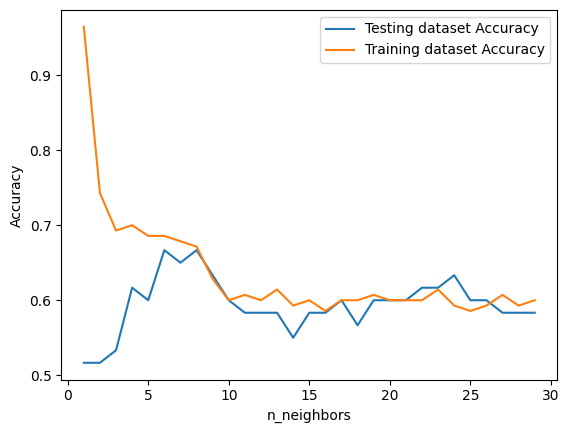

In [12]:
# here we want to look for the best value for k 
# so we can use for the kNN model 
# k is at its best when the testing and training accuracy lines meet
neighbors = np.arange(1, 30) 

train_accuracy_value = np.empty(len(neighbors)) 

test_accuracy_value = np.empty(len(neighbors)) 

  
# Looping through k values of range 1 to 30

for i, k in enumerate(neighbors): 

    knn = KNeighborsClassifier(n_neighbors=k) 

    knn.fit(X_train, y_train) 

      

    # Compute training and test data accuracy 

    train_accuracy_value[i] = knn.score(X_train, y_train) 

    test_accuracy_value[i] = knn.score(X_test, y_test) 

  
# Generate plot 

plt.plot(neighbors, test_accuracy_value, label = 'Testing dataset Accuracy') 

plt.plot(neighbors, train_accuracy_value, label = 'Training dataset Accuracy') 

  
plt.legend() 

plt.xlabel('n_neighbors') 

plt.ylabel('Accuracy') 
plt.show() 

In [13]:
print(X_train.shape, y_train.shape)

(140, 8515) (140,)


In [14]:
# KNN model
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_train=knn.score(X_train,y_train)
knn_test=knn.score(X_test,y_test)
print("Training set score", knn_train)
print("Testing set score", knn_test)
training_scores.append(knn_train)
testing_scores.append(knn_test)

Training set score 0.6285714285714286
Testing set score 0.6333333333333333


In [15]:
# adding more features with a degree of 3 for svm
poly = PolynomialFeatures(degree=3)
power_poly = poly.fit_transform(power)

# another way of scaling data
power_scale = preprocessing.scale(power_poly)

print(power_scale.shape)

(200, 374660)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(power_scale, data_labels_array,  test_size=0.3, random_state=42)

# SVM model using RBf as kernel
from sklearn.svm import SVC
svm = SVC(kernel='rbf',C = 0.1)
svm.fit(X_train, y_train)
svm_train=svm.score(X_train,y_train)
svm_test=svm.score(X_test,y_test)
print("Training set score", svm_train)
print("Testing set score", svm_test)
training_scores.append(svm_train)
testing_scores.append(svm_test)

Training set score 0.2785714285714286
Testing set score 0.18333333333333332


In [17]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(power)
print(power.shape)

(200, 129)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(scaler_data, data_labels_array,  test_size=0.3, random_state=42)

RandomClassifer =RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)
rf=RandomClassifer.fit(X_train, y_train)
rf_train = RandomClassifer.score(X_train,y_train)
rf_test = RandomClassifer.score(X_test,y_test)
print("Training set score", rf_train)
print("Testing set score", rf_test)
training_scores.append(rf_train)
testing_scores.append(rf_test)

Training set score 0.8428571428571429
Testing set score 0.5833333333333334


In [19]:
for i in testing_scores:
    print(i*100)

63.33333333333333
18.333333333333332
58.333333333333336


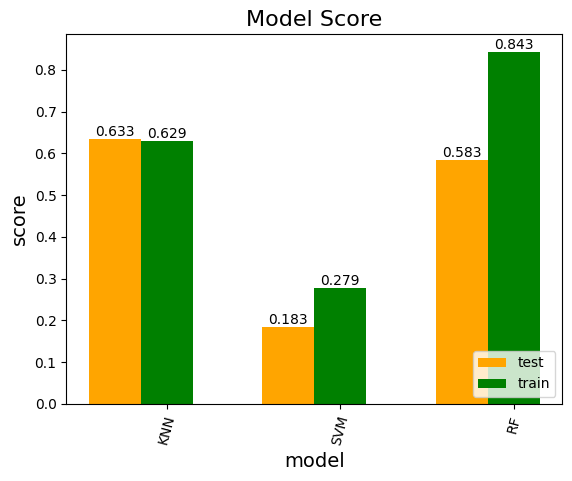

In [20]:
# ploting the accuracy for each of the three models
model_name = ["KNN","SVM","RF"]
import matplotlib.pyplot as plt
plt.title('Model Score', fontsize=16)
plt.xlabel('model', fontsize=14)
plt.ylabel('score', fontsize=14)

x = np.arange(3)

test = plt.bar(x - 0.3, testing_scores, 0.3, color='orange', label='test', align='center')
train = plt.bar(x, training_scores, 0.3, color='green', label='train', align='center')

for i in test + train:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width() / 2, h, '%.3f' % h, ha='center', va='bottom')
plt.xticks(x,model_name,rotation=75)
plt.legend(loc='lower right')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cdcd7b7a-2caf-40ce-9cca-562e2f317a32' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>